Universidad de Costa Rica  <br>
CI-0148 Aprendizaje Máquina <br>
Período: 2022-I <br>
Docente: Pablo Sauma Chacón <br>
Estudiantes: 

- Jose Pablo Mora Villalobos. B85326 
***

# Laboratorio 9

Objetivo: Familiarizar al estudiante con la implementación y uso de algoritmos de aprendizaje no supervisado.

[Descripción del laboratorio](https://docs.google.com/document/d/1jSGVmTt6GVpKD_skHySiH3wWigzqbE0I4vH38m77ezw/edit)

## 1. Carga de librerías de python

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.spatial.distance import cityblock
import random
from PIL import Image

## 2. Carga de imágenes y visualización

`load_image()` sirve para crear los arreglos de numpy con las imágenes de con un tamaño seleccionado. `plot_image()` y `plot_pallete()` muestran la imagen y la paleta de colores respectivamente.

In [3]:
def load_image(filename, resize):
    image = Image.open(filename).convert('RGB') 
    image.thumbnail(resize, Image.ANTIALIAS)
    if resize: image = image.resize(resize,Image.LANCZOS)
    image = np.array(image, dtype=np.float32) / 255
    image = np.moveaxis(image, 2, 0)
    return(image)

def plot_image(img,save=False,name=None,show=True):
    cmap = 'gray' if img.shape[0]==1 else None
    data = (img*(255  if img.max()<=1 else 1)).transpose((1,2,0)).astype(np.uint8)
    plt.figure()
    plt.imshow(data.squeeze(),cmap=cmap)
    if show:
        plt.show()
    if save:
        if img.shape[0]==1:
            plt.imsave(name, data.squeeze(), cmap=cmap)
        else:
            plt.imsave(name, data, cmap=cmap)
    plt.close()
    return np.array(Image.fromarray(data.squeeze()))

def plot_pallete(centroids_1,centroids_2,centroids_3,centroids_4):
    fig, axs = plt.subplots(4,1,sharex=True)
    plt.subplots_adjust(hspace=0.7)
    for ax in fig.get_axes():
        ax.axes.yaxis.set_visible(False)
    axs[0].imshow(centroids_1[0])
    axs[0].set_title(f'Means-Euc Dist: {centroids_1[1]:.2f}')
    axs[1].imshow(centroids_2[0])
    axs[1].set_title(f'Means-Man Dist: {centroids_2[1]:.2f}')
    axs[2].imshow(centroids_3[0])
    axs[2].set_title(f'Medoid-Euc Dist: {centroids_3[1]:.2f}')
    axs[3].imshow(centroids_4[0])
    axs[3].set_title(f'Medoid-Man Dist: {centroids_4[1]:.2f}')

    return fig



## 3. Cálculos de distancias

Para la distancia entre dos puntos se utilizaron las distancias manhattan y euclidiana

In [4]:
def euclidean_distance(p1,p2):
    dist = 0
    for p, q in zip(p1,p2):
        dist += (p-q)**2
    return math.sqrt(dist)

In [5]:
def manhattan_distance(p1,p2):
    dist = 0
    for p,q in zip(p1,p2):
        dist += abs(p-q)
    return dist

## 4. Selección del centroide

Para determinar el cluster de un punto se utiliza la función `nearest_centroid()` que retorna el número del cluster y la distancia a su centro.

In [6]:
def nearest_centroid(point, centroids, distance):
    idx_centroid = 0
    dist = np.inf
    for centroid in range(len(centroids)):
        new_dist = distance(point,centroids[centroid])
        if new_dist < dist:
            idx_centroid = centroid
            dist = new_dist
    return (idx_centroid,dist)
nearest_centroid((1,2,3),[(2,15,15),(5,7,15)],euclidean_distance)

(1, 13.601470508735444)

## 5. Algoritmo de Lloyd

`lloyd()` calcula todos los cluster a los que pertenecen los puntos de la imagen y actualiza los centroides cada iteración del algoritmo, de acuerdo a la distancia (euclidiana o manhattan) y al tipo (k-mean o k-medoid) elegidos.

In [9]:
def calc_centroids(data,centroids,distance):
    total_dist = 0
    new_centroids = [[] for _ in range(len(centroids))]
    for i in range(data.shape[1]):
            for j in range(data.shape[2]):
                idx_centroid, dist = nearest_centroid(data[:,i,j],centroids,distance)
                new_centroids[idx_centroid].append(data[:,i,j])
                total_dist += dist
    return new_centroids, total_dist

def get_centroids(data,k):
    centroids = np.zeros((k,len(data.shape)))
    for i in range(k):
        x = random.randint(0,data.shape[1]-1)
        y = random.randint(0,data.shape[2]-1)
        centroids[i] = [data[0,x,y],data[1,x,y],data[2,x,y]]
    return centroids

def lloyd(data, k, iters, type, distance):
    centroids = get_centroids(data,k)
    iter_ = 0
    current_dist = np.inf
    stop_f = False
    while iter_ < iters and not stop_f:
        new_centroids, new_dist = calc_centroids(data,centroids,distance)

        # print(iter_ ,new_dist - current_dist,new_dist , current_dist)
        if type == 'means':            
            if abs(new_dist - current_dist) < 0.001:
                stop_f = True
            else:
                current_dist = new_dist
                for i in range(len(centroids)):
                    if not new_centroids[i]: continue
                    centroids[i] = np.mean(new_centroids[i], axis=0)
        elif type == 'medoid':
            current_dist = new_dist
            for i in range(len(centroids)):
                if not new_centroids[i]: continue
                new_centroid = random.choice(new_centroids[i])
                current_centroid_dist = 0
                new_centroid_dist = 0
                for point in new_centroids[i]:
                    current_centroid_dist += distance(centroids[i],point)
                    new_centroid_dist+=distance(new_centroid,point)
                if new_centroid_dist < current_centroid_dist:
                    centroids[i] = new_centroid
        iter_+=1

    centroids = np.array(centroids).reshape((1,k,3))
    return centroids, current_dist
    


## 6. Corrida del algoritmo de Lloyd

Para ver el resultado del algoritmo de Lloyd, se hicieron tres corrida por cada combinación de tipo y distancia por imagen, esto debido a que los centroides se eligen aleatoriamente. Se seleccionaron 5 clusters y 50 iteraciones. Para las distancias se usaron las funciones `dist()` y `cityblocks()` de las librerías `math` y `scipy.spatial.distance`, en vez de la programadas debido a que eran más eficientes y tardaban menos en hacer los cálculo, sin embargo las funciones `euclidean_distance()` y `manhattan_distance()` dan los mismos resultados. Por último, corrí el algoritmo con 10 imágenes porque me pareció interesante ver el resultado con cada una.

En todos los casos la distancia euclidiana tuvo menos distancia total que la manhattan, pero esto es de esperar debido a la forma de calcular esta distancia, dos puntos iguales van a tener mayor distancia manhattan que con euclidiana. Por otro lado, los algoritmos k-means y k-medoid tuvieron un comportamiento parecido para la misma distancia. En general, la paleta de colores es bastante parecida independientemente de la combinación, salvo en muy pocas excepciones. 

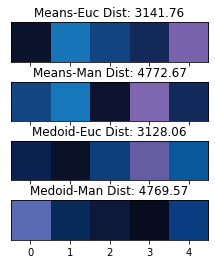

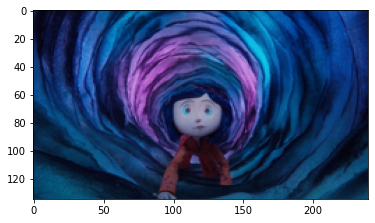

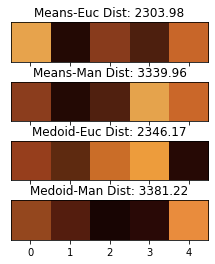

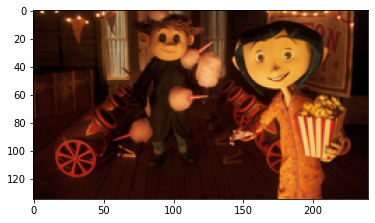

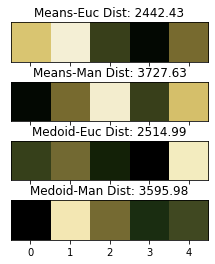

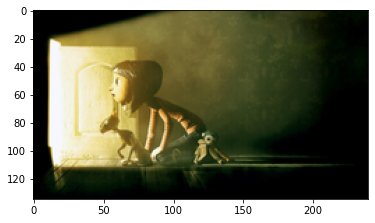

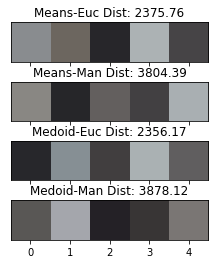

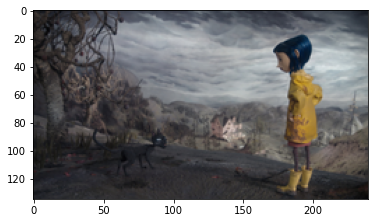

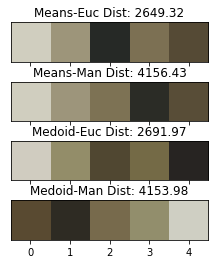

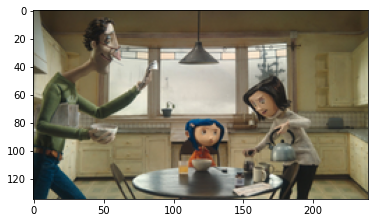

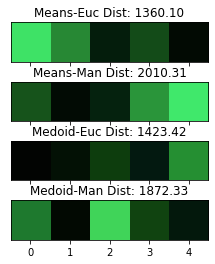

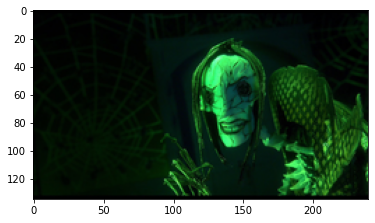

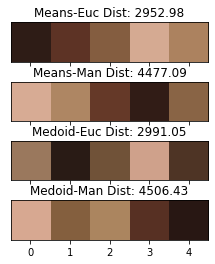

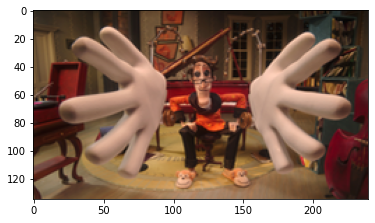

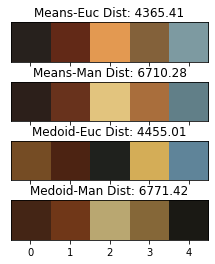

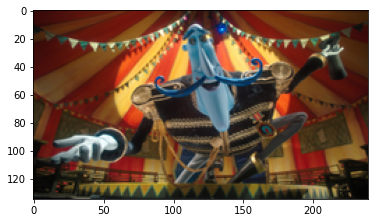

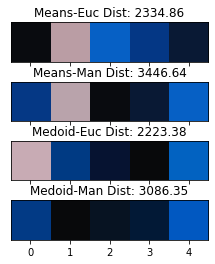

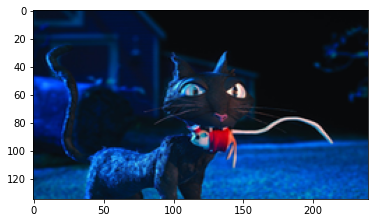

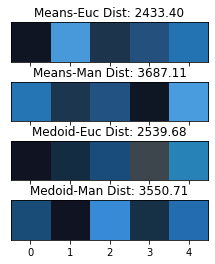

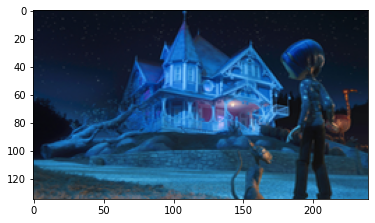

In [31]:
def run_lloyd(image,k,iters,type,distance,tries):
    min_dist = np.inf
    min_centroids = None
    for i in range(tries):
        centroids,dist = lloyd(image,k,iters,type,distance)
        if dist < min_dist:
            min_dist = dist
            min_centroids = centroids
    return min_centroids,min_dist


if __name__ == '__main__':
    
    for i in range(10):
        try:
            image = load_image(f'images/coraline_{i+1}.jpg',(240,135))
        except:
            continue
        # Means - Euclidean
        centroids_1 = run_lloyd(image,5,50,'means',math.dist,3)
        # Means - Manhattan
        centroids_2 = run_lloyd(image,5,50,'means',cityblock,3)
        # Medoids - Euclidean
        centroids_3 = run_lloyd(image,5,50,'medoid',math.dist,3)
        # Medoids - Manhattan
        centroids_4 = run_lloyd(image,5,50,'medoid',cityblock,3)
        plot_pallete(centroids_1,centroids_2,centroids_3,centroids_4)
        a = plot_image(image)